# Data anaylsis in cerebellar granular layer simulations
## Only MF-GrC plasticity mechanism enabled - 4mf per GrC
First, we set current working directory to the root of Spiking Granular Layer and insert the source folder to the python path:

In [1]:
import os
os.chdir('../../..')
os.getcwd()
import sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(1,'./src')

## Running the simulation
Now start setting a new simulation with the configuration file that we specify:

In [2]:
config_file = './config/GoCGrCHitTop/SimulationConfigOnlyMFGrC4.cfg'
data_path = './results'
simulation_name = 'MFGrCPlasticity-Top-Hit-500'
simulation_time = 1500.0
analysis_time = 500.0
run_the_simulation = False
import SpikingSimulation.FrequencySimulation as FrequencySimulation
simulation = FrequencySimulation.FrequencySimulation(config_file=config_file)

Initialize the simulation. If run_the_simulation is true it will run the long simulation and record the activity, network, weights, state variables and stimulation patterns to some files. Otherwise the simulation will be loaded from the files.

In [3]:
simulation.config_options['simulation']['verbosity'] = 'Info'
simulation.config_options['simulation']['seed'] = 123456
simulation.config_options['simulation']['time'] = simulation_time
simulation.config_options['simulation']['data_path'] = data_path
simulation.config_options['simulation']['simulation_name'] = simulation_name
simulation.config_options['simulation']['register_activity_only_in_test'] = False
simulation.config_options['simulation']['run_simulation'] = run_the_simulation
simulation.config_options['simulation']['record_to_file'] = run_the_simulation
simulation.config_options['simulation']['state_recording_step'] = 100
if run_the_simulation:
    simulation.config_options['network']['load_file'] = None
else:
    simulation.config_options['network']['load_file'] = data_path + '/' + simulation_name + '/network.h5'
simulation.config_options['stimulation']['load_pattern_file'] = None
simulation.config_options['mflayer']['register_activity'] = True
simulation.config_options['grclayer']['register_activity'] = True
simulation.config_options['goclayer']['register_activity'] = True
simulation.config_options['grclayer']['save_state_vars'] = 'Vth'
simulation.config_options['grclayer']['load_state_vars'] = 'Vth'
simulation.config_options['grclayer']['record_vars'] = 'Vth'
simulation.config_options['goclayer']['save_state_vars'] = 'Vth'
simulation.config_options['goclayer']['load_state_vars'] = 'Vth'
simulation.config_options['goclayer']['record_vars'] = 'Vth'
simulation.config_options['mfgrcsynapsis']['weight_recording'] = True
simulation.config_options['mfgocsynapsis']['weight_recording'] = True
simulation.config_options['grcgocsynapsis']['weight_recording'] = True
simulation.config_options['gocgrcsynapsis']['weight_recording'] = True
simulation.config_options['gocgocsynapsis']['weight_recording'] = True
simulation.initialize()

2017-03-28 11:56:52,565 - P19274 - MemTotal:76M - Simulation - WARNING: Non-specified cell model parameter: tau_minus in layer mflayer. Using default value
2017-03-28 11:56:52,590 - P19274 - MemTotal:76M - Simulation - WARNING: Non-specified cell model parameter: tau_istdp in layer mflayer. Using default value
2017-03-28 11:56:52,592 - P19274 - MemTotal:76M - Simulation - WARNING: Non-specified number of neurons in layer mflayer
2017-03-28 11:56:52,596 - P19274 - MemTotal:77M - Simulation - WARNING: Non-specified number of neurons in layer grclayer
2017-03-28 11:56:52,604 - P19274 - MemTotal:77M - Simulation - WARNING: Non-specified number of neurons in layer goclayer


Run the simulation

In [4]:
#simulation.visualize_animation()
simulation.run_simulation()

2017-03-28 11:56:55,839 - P19274 - MemTotal:499M - Simulation - INFO: Running the simulation from 0.0s until time 1500.0s


## Mossy Fibers Activity Analysis

Plot the firing offset vs the activation level

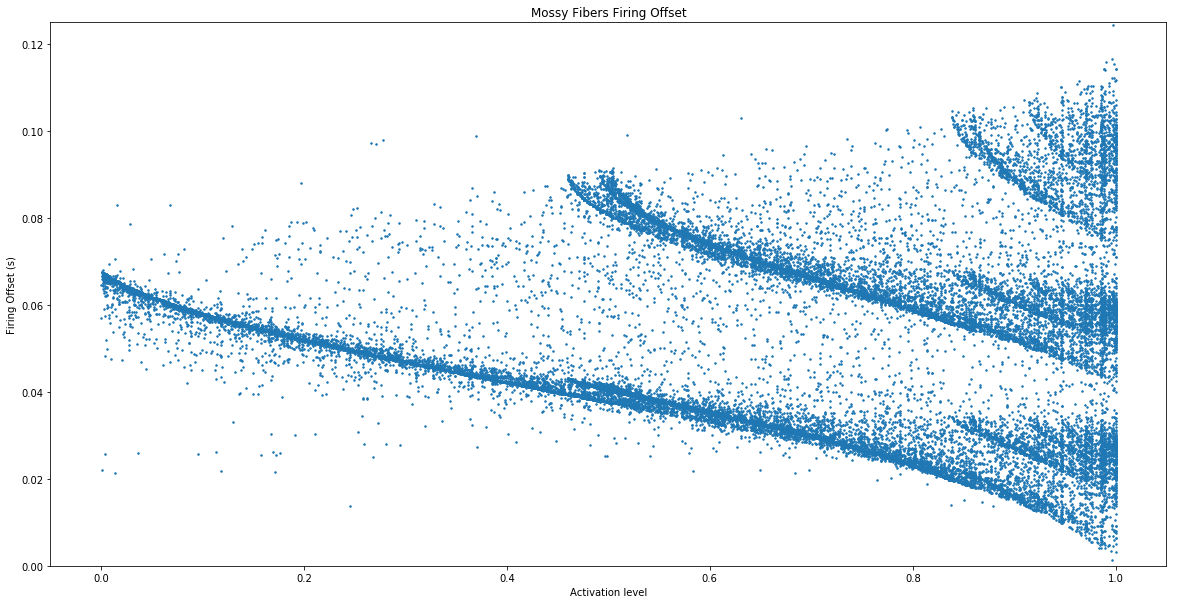

In [5]:
oscillation_frequency = simulation.config_options['oscillations']['frequency']
gtime_mf,gcell_id_mf = simulation.cerebellum.get_spike_activity(neuron_layer = 'mflayer',
                                                          init_time = simulation_time-10.0, 
                                                          end_time = simulation_time)
bin_id = numpy.searchsorted(simulation.pattern_generator.pattern_length_cum, gtime_mf)
firing_offset = numpy.mod(gtime_mf,1./oscillation_frequency)
plt.figure(figsize=(20,10))
plt.plot(simulation.pattern_generator.activation_levels[bin_id,gcell_id_mf],firing_offset,'.',markersize=3)
plt.ylim([0,1./oscillation_frequency])
plt.xlabel('Activation level')
plt.ylabel('Firing Offset (s)')
plt.title('Mossy Fibers Firing Offset')

## GrC Connectivity Analysis

Histogram of input synapses for the granular cells

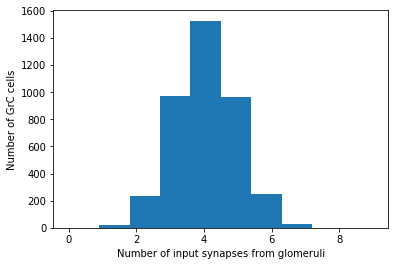

In [6]:
target_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
cell_number = simulation.cerebellum.layer_map['grclayer'].number_of_neurons
number_of_inputs = numpy.bincount(target_cell_index)
plt.hist(number_of_inputs, bins=10, range=(0,9))
plt.ylabel('Number of GrC cells')
plt.xlabel('Number of input synapses from glomeruli')

Weight histogram between MF and GrC

Number of active synapses MF-GrC: 7976


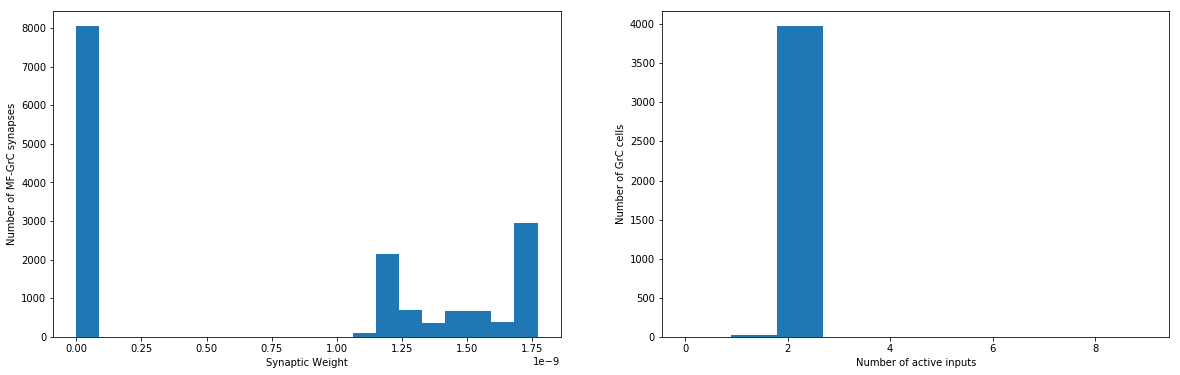

In [7]:
target_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
source_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].source_index
weight = simulation.cerebellum.layer_map['mfgrcsynapsis'].weights
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.hist(weight, bins=20)
plt.xlabel('Synaptic Weight')
plt.ylabel('Number of MF-GrC synapses')
max_weight = numpy.max(weight)
active_synapses = weight>max_weight*0.2
number_of_active_inputs = numpy.bincount(target_cell_index[active_synapses])
plt.subplot(1,2,2)
plt.hist(number_of_active_inputs, bins=10, range=(0,9))
plt.ylabel('Number of GrC cells')
plt.xlabel('Number of active inputs')
print 'Number of active synapses MF-GrC:',numpy.count_nonzero(active_synapses)

Histogram of active synapses connecting input fibers included in the pattern

Number of active MF-GrC synapses also included in pattern 0 : 1634
Number of active MF-GrC synapses also included in pattern 1 : 1731
Number of active MF-GrC synapses also included in pattern 2 : 1525
Number of active MF-GrC synapses also included in pattern 3 : 1666


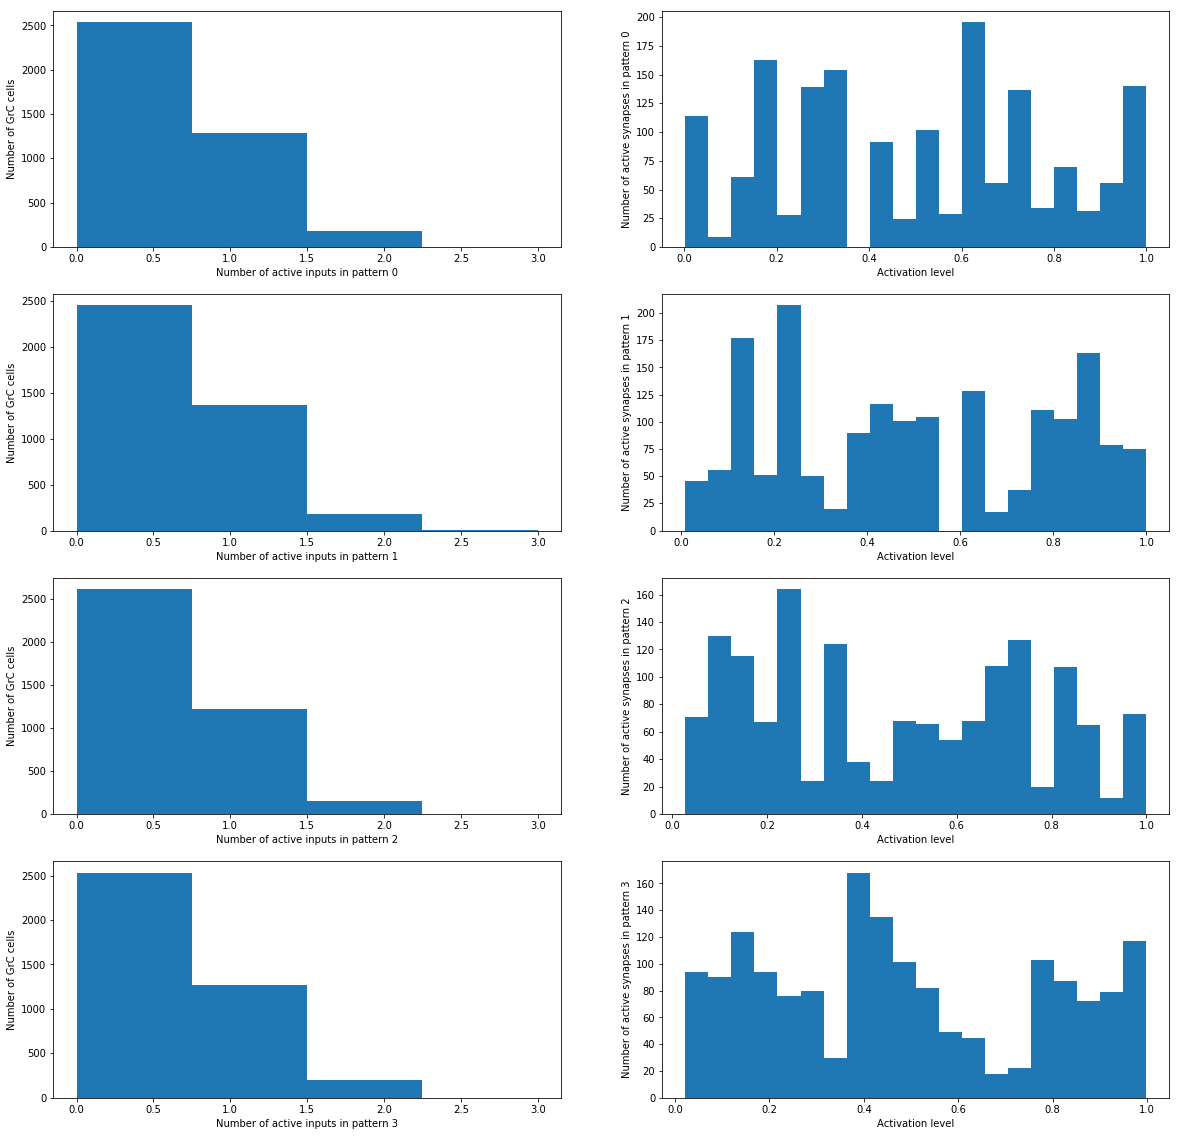

In [8]:
active_target_neurons = []
plt.figure(figsize=(20,20))
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(source_cell_index, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    included_and_active = numpy.logical_and(included_in_pattern,active_synapses)
    number_of_active_inputs_in_pattern = numpy.bincount(target_cell_index[included_and_active])
    active_target_neurons.append(numpy.where(number_of_active_inputs_in_pattern>=3)[0])
    plt.subplot(simulation.pattern_generator.number_of_patterns,2,pat_id*2+1)
    plt.hist(number_of_active_inputs_in_pattern, bins=simulation.pattern_generator.number_of_patterns, range=(0,simulation.pattern_generator.number_of_patterns-1))
    plt.ylabel('Number of GrC cells')
    plt.xlabel('Number of active inputs in pattern %s'%pat_id)
    print 'Number of active MF-GrC synapses also included in pattern',pat_id,':', numpy.count_nonzero(included_and_active)
    plt.subplot(simulation.pattern_generator.number_of_patterns,2,(pat_id+1)*2)
    activation_level = [simulation.pattern_generator.pattern_activation[pat_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pat_id,:]==source)[0][0]] 
                    for source in source_cell_index[included_and_active]]
    plt.hist(activation_level, bins=20)
    plt.ylabel('Number of active synapses in pattern %s'%pat_id)
    plt.xlabel('Activation level')

## GrC Activity Analysis

Calculate the average firing frequency for each granular cell during the analysis time

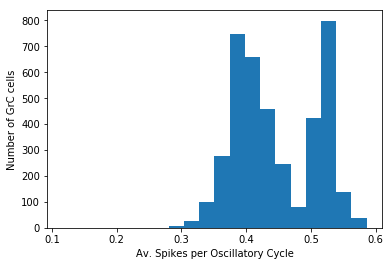

In [9]:
gtime,gcell_id = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = simulation_time-analysis_time, 
                                                          end_time = simulation_time)
oscillation_frequency = 8.0
import numpy
firing_frequency = numpy.bincount(gcell_id) / (analysis_time*oscillation_frequency)
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(firing_frequency, bins=20)
plt.ylabel('Number of GrC cells')
plt.xlabel('Av. Spikes per Oscillatory Cycle')

Define some auxiliar functions:

In [31]:
def calc_Ind_Pattern_Hit_Matrix(cell_firing, pattern_present):
    '''
    Calculate the correct rejection, hit, miss and false alarm matrisses with 1 line for each cell and 1 column for each pattern (including noise).
    @param cell_firing Boolean matrix including 1 line for each cell and 1 column for each time bin.
    @param pattern_present Boolean matrix including 1 line for each pattern and 1 column for each time bin.
    '''
    hit_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    cr_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    miss_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    fa_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    faa_matrix = numpy.empty((len(cell_firing)))
    
    for index_pat, pattern in enumerate(pattern_present):
        if (numpy.count_nonzero(pattern)):
            for index_cell, firing in enumerate(cell_firing):
                hit_matrix[index_pat,index_cell] = numpy.count_nonzero(firing&pattern)/float(numpy.count_nonzero(pattern))
                cr_matrix[index_pat,index_cell] = numpy.count_nonzero(~firing&~pattern)/float(numpy.count_nonzero(~pattern))
                miss_matrix[index_pat,index_cell] = numpy.count_nonzero(~firing&pattern)/float(numpy.count_nonzero(pattern))
                fa_matrix[index_pat,index_cell] = numpy.count_nonzero(firing&~pattern)/float(numpy.count_nonzero(~pattern))
        else:
            print 'Pattern',index_pat,'never occurs. Statistics will not be calculated'
               
    any_pattern = numpy.any(pattern_present, axis=0)
    for index_cell, firing in enumerate(cell_firing):
        faa_matrix[index_cell] = numpy.count_nonzero(firing&~any_pattern)/float(numpy.count_nonzero(~any_pattern))
        
    return cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix

def create_cell_firing_matrix(layer, init_time, window_length, time_bin):
    # Cell index is the list with all the neuron ids in the population 
    cell_index = range(simulation.cerebellum.get_number_of_elements(layer=layer))
    pattern_generator = simulation.pattern_generator
    num_cells = len(cell_index)
    
    inv_time_bin = 1./time_bin

    # Generate the time bin matrix
    bin_time_init = numpy.linspace(init_time, init_time+window_length-time_bin, num=window_length*inv_time_bin)
    bin_time_end = numpy.linspace(init_time+time_bin,init_time+window_length,num=window_length*inv_time_bin)
    num_bins = len(bin_time_init)
        
    # Final matrix indicating which bins are registered spikes
    bin_has_fired = numpy.empty((num_cells, num_bins), dtype='bool')
    bin_has_fired[:,:] = False

    # Create a map of cells to index
    cell_map = dict()
    for key, value in enumerate(cell_index):
        cell_map[value] = key

        
    gtime,gcell_id = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = init_time, 
                                                          end_time = init_time+window_length)
    # Calculate the bin index for each spike
    spike_time_index = numpy.logical_and(gtime>=init_time, gtime<=init_time+window_length)
    
    spike_bin_index = numpy.floor((gtime[spike_time_index]-init_time)*inv_time_bin).astype(int)

    # Calculate the cell index (not needed if cells are numbered from 0 to number_of_cells)
    cell_index = numpy.array([cell_map[value] for value in gcell_id[spike_time_index]])

    # Final matrix indicating which bins have spikes registered spikes
    if len(spike_bin_index) and len(cell_index):
        bin_has_fired[cell_index,spike_bin_index] = True
        
    return bin_has_fired

def create_active_pattern_matrix(init_time, window_length, time_bin):
    pattern_generator = simulation.pattern_generator
    inv_time_bin = 1./time_bin

    # Generate the time bin matrix
    bin_time_init = numpy.linspace(init_time, init_time+window_length-time_bin, num=window_length*inv_time_bin)
    bin_time_end = numpy.linspace(init_time+time_bin,init_time+window_length,num=window_length*inv_time_bin)
    num_bins = len(bin_time_init)
    
    # Initialize a matrix
    pattern_index = range(pattern_generator.number_of_patterns)
    
    # Calculate the time of each pattern interval
    # time_end_of_pattern is the accumulated of pattern bin lengths
    pattern_indexes = numpy.logical_and(pattern_generator.pattern_length_cum>=init_time, pattern_generator.pattern_length_cum<=init_time+window_length)
    time_end_of_pattern = pattern_generator.pattern_length_cum[pattern_indexes]
    time_init_of_pattern = numpy.append([init_time],time_end_of_pattern[:-1])

    # Create sparse representation of pattern presentation
    pattern_activation = numpy.empty((pattern_generator.pattern_length_cum.shape[0], pattern_generator.number_of_patterns), dtype='bool')
    pattern_activation[:] = False
    for index, pat_activation in enumerate(pattern_generator.pattern_id_index):
        pattern_activation[pat_activation,index] = True
    pattern_activation_in_window = pattern_activation[pattern_indexes,:]

    # Calculate the bin of each pattern interval. Check the round of the last bin to avoid out of range
    bin_end_of_pattern = numpy.floor((time_end_of_pattern-init_time) * inv_time_bin).astype(int)
    if (bin_end_of_pattern[-1]>=num_bins):
        bin_end_of_pattern[-1]=num_bins-1
    bin_init_of_pattern = numpy.append([0],bin_end_of_pattern[:-1])
    if (bin_init_of_pattern[-1]>=num_bins):
        bin_init_of_pattern[-1]=num_bins-1

    # Final matrix indicating which bins are considered of each pattern
    bin_is_pattern = numpy.empty((pattern_generator.number_of_patterns, num_bins),dtype='bool')
    bin_is_pattern[:,:] = False
    bin_pattern = numpy.zeros(num_bins)

    # How-to calculate pattern_generator.pattern_id_index
    # Select the pattern bins where each pattern is presented
    # pattern_activation is the dataset with the same name in the stimulation file

    pattern_id_index = numpy.array([numpy.where(pattern_activation_in_window[:,num_pattern])[0] for num_pattern in range(pattern_generator.number_of_patterns)])

    # Calculate if each time-bin receives stimulation (at least half of the time) from each pattern
    for key, value in enumerate(pattern_index):
        time_of_pattern_in_bin = numpy.zeros(num_bins)
        for index in pattern_id_index[value]:
            init_bin = bin_init_of_pattern[index]
            end_bin = bin_end_of_pattern[index]

            list_of_bins = range(init_bin,end_bin+1)

            # Add the time of the initial bin (if exists)
            if init_bin!=end_bin:
                time_of_pattern_in_bin[list_of_bins[0]] += (bin_time_end[init_bin] - time_init_of_pattern[index])

            # Add the time of the intermediate bins (if exist)
            time_of_pattern_in_bin[list_of_bins[1:-1]] += time_bin

            # Add the time of the final bin
            time_of_pattern_in_bin[list_of_bins[-1]] += (time_end_of_pattern[index] - max(time_init_of_pattern[index],bin_time_init[end_bin]))

        # Those bins where the time in the pattern is longer than half of the bin are set to part of that pattern    
        bin_is_pattern[key,time_of_pattern_in_bin>(time_bin/2.)] = True
        bin_pattern[bin_is_pattern[key,:]] = bin_pattern[bin_is_pattern[key,:]] + 2**value

    # Calculate mutual information in the time window
    init_bin = 0
    end_bin = int(window_length * inv_time_bin)
    
    return bin_is_pattern

def create_input_activation_matrix(init_time, window_length, time_bin):
    
    pattern_generator = simulation.pattern_generator
    inv_time_bin = 1./time_bin

    # Generate the time bin matrix
    bin_time_init = numpy.linspace(init_time, init_time+window_length-time_bin, num=window_length*inv_time_bin)
    bin_time_end = numpy.linspace(init_time+time_bin,init_time+window_length,num=window_length*inv_time_bin)
    num_bins = len(bin_time_init)
    
    # Calculate the time of each pattern interval
    # time_end_of_pattern is the accumulated of pattern bin lengths
    pattern_indexes = numpy.logical_and(pattern_generator.pattern_length_cum>=init_time, pattern_generator.pattern_length_cum<=init_time+window_length)
    time_end_of_pattern = pattern_generator.pattern_length_cum[pattern_indexes]
    time_init_of_pattern = numpy.append([init_time],time_end_of_pattern[:-1])

    # Calculate the bin of each pattern interval. Check the round of the last bin to avoid out of range
    bin_end_of_pattern = numpy.floor((time_end_of_pattern-init_time) * inv_time_bin).astype(int)
    if (bin_end_of_pattern[-1]>=num_bins):
        bin_end_of_pattern[-1]=num_bins-1
    bin_init_of_pattern = numpy.append([0],bin_end_of_pattern[:-1])
    if (bin_init_of_pattern[-1]>=num_bins):
        bin_init_of_pattern[-1]=num_bins-1

    # Calculate the number of mossy fibers from the activation levels matrix
    fiber_number = pattern_generator.activation_levels.shape[1]
    
    # Final matrix indicating which bins are considered of each pattern
    input_activation = numpy.empty((fiber_number, num_bins),dtype='float')
    input_activation[:,:] = 0.0

    # Calculate if each time-bin receives stimulation (at least half of the time) from each pattern
    for index in range(bin_init_of_pattern.shape[0]):
        
        init_bin = bin_init_of_pattern[index]
        end_bin = bin_end_of_pattern[index]

        list_of_bins = range(init_bin,end_bin+1)

        # Add the time of the initial bin (if exists)
        if init_bin!=end_bin:
            input_activation[:,init_bin] += pattern_generator.activation_levels[index,:]*(bin_time_end[init_bin] - time_init_of_pattern[index])

        # Add the time of the intermediate bins (if exist)
        for num_bin in list_of_bins[1:-1]:
            input_activation[:,num_bin] += pattern_generator.activation_levels[index,:]*(time_bin)

        # Add the time of the final bin
        input_activation[:,end_bin] += pattern_generator.activation_levels[index,:]*(time_end_of_pattern[index] - max(time_init_of_pattern[index],bin_time_init[end_bin]))

    input_activation = input_activation/time_bin
    
    return input_activation

def analyze_activity(layer, init_time, window_length, time_bin):

    bin_has_fired = create_cell_firing_matrix(layer, init_time, window_length, time_bin)
    bin_is_pattern = create_active_pattern_matrix(init_time, window_length, time_bin)
        
    # Calculate hit matrix for each pattern
    cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix = calc_Ind_Pattern_Hit_Matrix(bin_has_fired, bin_is_pattern)

    return cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix, bin_has_fired

Represent the hit rate matrix of each GrC to each pattern

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Product of cell rate assigned to each pattern: 0.000641836416375 over 0.00390625


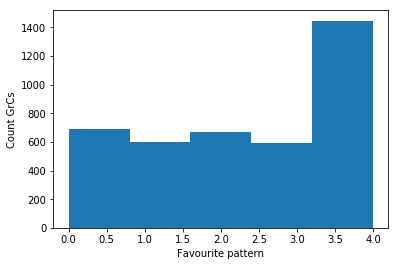

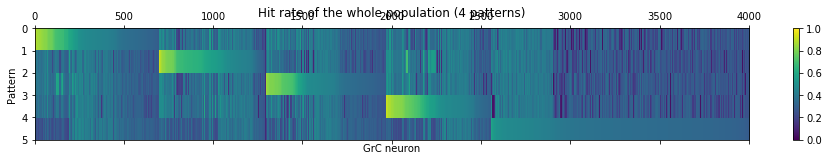

In [11]:
layer = 'grclayer'
window_length = simulation.config_options['hit_top_analysis']['window_length'] = analysis_time
time_bin = simulation.config_options['hit_top_analysis']['time_bin'] = 0.125

cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix, bin_has_fired = analyze_activity(layer, simulation_time-window_length, window_length, time_bin)

#numpy.set_printoptions(threshold=numpy.nan)
#print 'Individual pattern hit matrix:'
#print hit_matrix
#print 'Individual pattern correct rejection matrix:'
#print cr_matrix
#print 'Individual pattern miss matrix:'
#print miss_matrix
#print 'Individual pattern false alarm matrix:'
#print fa_matrix
#print 'All patterns false alarm array:'
#print faa_matrix

extended_hit = numpy.append(hit_matrix, [faa_matrix], axis=0)
selected_pattern = numpy.argmax(extended_hit, axis=0)
plt.figure()
n,bins,_=plt.hist(selected_pattern, bins=simulation.pattern_generator.number_of_patterns+1)
plt.ylabel('Count GrCs')
plt.xlabel('Favourite pattern')
#cell_sorted = numpy.argsort(selected_pattern)
hit_rate_selected = extended_hit[selected_pattern,range(simulation.cerebellum.get_number_of_elements(layer=layer))]
cell_sorted = numpy.lexsort((1.-hit_rate_selected,selected_pattern))
plt.figure(figsize=(20,10))
plt.matshow(extended_hit[:,cell_sorted], extent=[0,simulation.cerebellum.get_number_of_elements(layer=layer),
                                                 simulation.pattern_generator.number_of_patterns+1,0], 
            vmin=0, vmax=1.0, aspect='auto')
plt.ylabel('Pattern')
plt.xlabel('GrC neuron')
plt.title('Hit rate of the whole population (%s patterns)'%simulation.pattern_generator.number_of_patterns)
plt.colorbar()
cells_mult = numpy.prod(n[:-1]/simulation.cerebellum.layer_map['grclayer'].number_of_neurons)
max_mult = pow(1./simulation.pattern_generator.number_of_patterns,simulation.pattern_generator.number_of_patterns)
print 'Product of cell rate assigned to each pattern:', cells_mult, 'over', max_mult

Plot the hit-rate and false alarm for each neuron and pattern

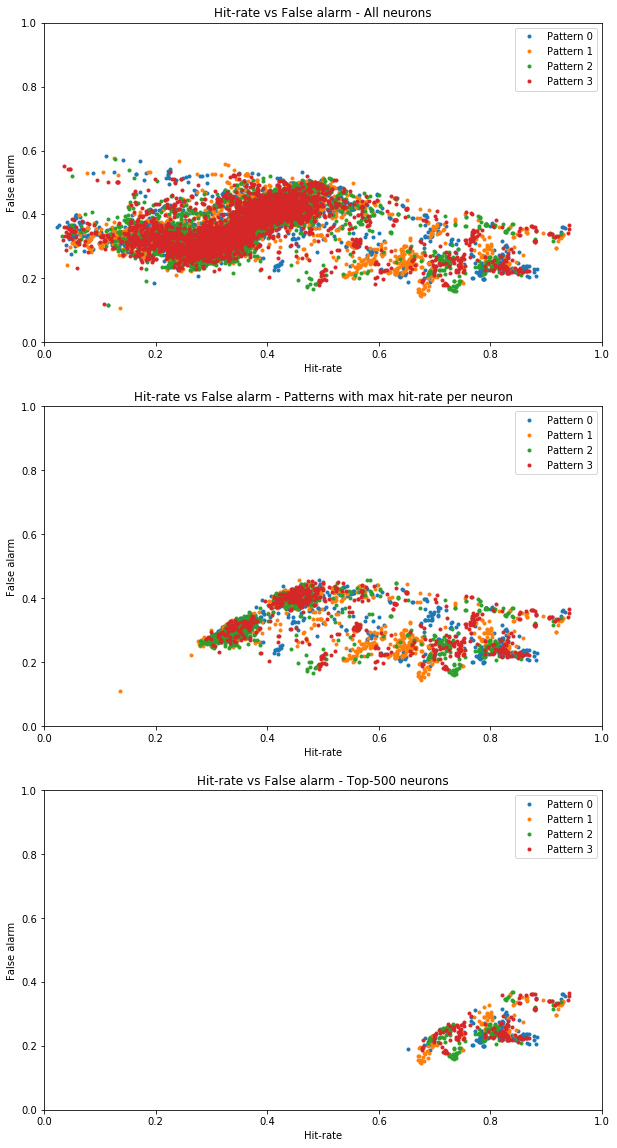

In [12]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
patterns_to_show = range(simulation.pattern_generator.number_of_patterns)
#patterns_to_show = [3]
for pat_id in patterns_to_show:
    plt.plot(hit_matrix[pat_id,:], fa_matrix[pat_id,:],'.',label='Pattern %s'%pat_id)
plt.title('Hit-rate vs False alarm - All neurons')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.xlabel('Hit-rate')
plt.ylabel('False alarm')
plt.legend()
plt.subplot(3,1,2)
patterns_to_show = range(simulation.pattern_generator.number_of_patterns)
#patterns_to_show = [3]
for pat_id in patterns_to_show:
    plt.plot(hit_matrix[pat_id,selected_pattern==pat_id], fa_matrix[pat_id,selected_pattern==pat_id],'.',label='Pattern %s'%pat_id)
plt.title('Hit-rate vs False alarm - Patterns with max hit-rate per neuron')
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.xlabel('Hit-rate')
plt.ylabel('False alarm')
plt.legend()

# Select those cells mainly responding to one of the patterns
selected_neurons = numpy.where(selected_pattern<simulation.pattern_generator.number_of_patterns)[0]

pattern_id_selected = selected_pattern[selected_neurons]
diagonal = hit_matrix[pattern_id_selected,selected_neurons]
fa_diagonal = fa_matrix[pattern_id_selected,selected_neurons]
hit_fa_diff_per_cell = diagonal - fa_diagonal

# Get the hit_fa_diff for the top-n neurons as the histogram of patterns represented
n = 500
ind_top = numpy.argsort(hit_fa_diff_per_cell)[-n:]
top_neurons = selected_neurons[ind_top]
top_patterns = pattern_id_selected[ind_top]
hit_fa_diff_top = hit_fa_diff_per_cell[ind_top]

plt.subplot(3,1,3)
patterns_to_show = range(simulation.pattern_generator.number_of_patterns)
#patterns_to_show = [3]
for pat_id in patterns_to_show:
    plt.plot(hit_matrix[pat_id,top_neurons[top_patterns==pat_id]], fa_matrix[pat_id,top_neurons[top_patterns==pat_id]],'.',label='Pattern %s'%pat_id)
plt.title('Hit-rate vs False alarm - Top-%s neurons'%n)
plt.xlim([0,1.0])
plt.ylim([0,1.0])
plt.xlabel('Hit-rate')
plt.ylabel('False alarm')
plt.legend()

Hit-rate and false alarm analysis

Average hits of selected elements: 0.534528391127
Average hits of non-selected elements: 0.373608986333
Average false alarm: 0.320450556374
Difference hit-false alarms per cell: [ 0.33556939  0.44269783  0.30728117 ...,  0.03562382  0.08612142
  0.03019102]
Average hit-false alarms per top-n cells with n= 500 : 0.544856896873
Min hit-false alarms per top-n cells: 0.456831737231
Max hit-false alarms per top-n cells: 0.675548544866
Hit index: 0.160919404795


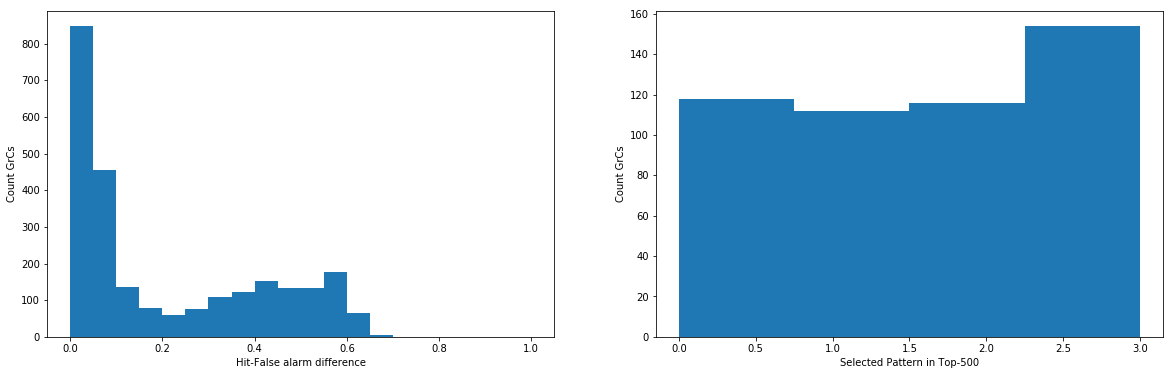

In [13]:
top_n_average = numpy.average(hit_fa_diff_per_cell[ind_top])

# Create a new matrix setting the diagonal values to zero
zero_matrix = numpy.copy(hit_matrix)
zero_matrix[pattern_id_selected,selected_neurons] = 0.0

# Calculate the average of the diagonal elements
av_selected = numpy.average(diagonal)
av_nonselected = numpy.sum(zero_matrix[:])/(simulation.cerebellum.get_number_of_elements(layer=layer)*(simulation.pattern_generator.number_of_patterns-1))
av_fa_selected = numpy.average(fa_diagonal)
print 'Average hits of selected elements:',av_selected
print 'Average hits of non-selected elements:',av_nonselected
print 'Average false alarm:',av_fa_selected
print 'Difference hit-false alarms per cell:', hit_fa_diff_per_cell
print 'Average hit-false alarms per top-n cells with n=',n,':', top_n_average
print 'Min hit-false alarms per top-n cells:',numpy.min(hit_fa_diff_per_cell[ind_top])
print 'Max hit-false alarms per top-n cells:',numpy.max(hit_fa_diff_per_cell[ind_top])
hit_index = av_selected - av_nonselected
print 'Hit index:',hit_index
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.hist(hit_fa_diff_per_cell, bins=20, range=(0,1))
plt.ylabel('Count GrCs')
plt.xlabel('Hit-False alarm difference')

unique_pattern = numpy.unique(top_patterns)
if (unique_pattern.size<simulation.pattern_generator.number_of_patterns):
    print 'Warning: Some patterns are not represented in top-n neurons.'
plt.subplot(1,2,2)
plt.hist(top_patterns, bins=simulation.pattern_generator.number_of_patterns, range=(0,simulation.pattern_generator.number_of_patterns-1))
plt.ylabel('Count GrCs')
plt.xlabel('Selected Pattern in Top-%s'%n)

## Sparseness, Pattern Expansion and Population Correlation

Calculate Population Sparseness for the whole population

In [14]:
square_hit = hit_matrix*hit_matrix
row_square_sum = numpy.sum(square_hit,axis=1)
row_sum = numpy.sum(hit_matrix,axis=1)
row_sum_square = row_sum * row_sum
num_grc = simulation.cerebellum.layer_map['grclayer'].number_of_neurons
sparseness_per_pattern = (num_grc - (row_sum_square/row_square_sum))/(num_grc-1)
print 'Sparseness per pattern: %s'%sparseness_per_pattern.tolist()
average_sparseness = numpy.average(sparseness_per_pattern)
print 'Average sparseness: %s'%average_sparseness

Sparseness per pattern: [0.11167626005430674, 0.11798110545874221, 0.09669301386579551, 0.12263794544198879]
Average sparseness: 0.112247081205


Calculate population sparseness for top-ranked neurons

In [15]:
square_hit = hit_matrix[:,top_neurons]*hit_matrix[:,top_neurons]
row_square_sum = numpy.sum(square_hit,axis=1)
row_sum = numpy.sum(hit_matrix[:,top_neurons],axis=1)
row_sum_square = row_sum * row_sum
num_grc = n
sparseness_per_pattern = (num_grc - (row_sum_square/row_square_sum))/(num_grc-1)
print 'Sparseness per pattern: %s'%sparseness_per_pattern.tolist()
average_sparseness = numpy.average(sparseness_per_pattern)
print 'Average sparseness: %s'%average_sparseness

Sparseness per pattern: [0.15322067570908157, 0.13737928407077865, 0.12647294566711356, 0.16255411426652835]
Average sparseness: 0.144906754928


Calculate pattern expansion for the whole population

In [16]:
neuron_variance = numpy.var(bin_has_fired,axis=1)
total_variance = numpy.sum(neuron_variance)
print 'Pattern expansion - Total variance: %s'%total_variance
average_variance = total_variance/simulation.cerebellum.layer_map['grclayer'].number_of_neurons
print 'Pattern expansion - Average variance per neuron: %s'%average_variance

Pattern expansion - Total variance: 904.80800625
Pattern expansion - Average variance per neuron: 0.226202001563


Calculate pattern expansion for top-ranked neurons

In [17]:
neuron_variance = numpy.var(bin_has_fired[top_neurons,:],axis=1)
total_variance = numpy.sum(neuron_variance)
print 'Pattern expansion - Total variance: %s'%total_variance
average_variance = total_variance/n
print 'Pattern expansion - Average variance per neuron: %s'%average_variance

Pattern expansion - Total variance: 118.22250725
Pattern expansion - Average variance per neuron: 0.2364450145


Calculate the whole-population correlation

In [18]:
average_population_hit_rate = numpy.average(bin_has_fired[:])
bin_firing_rate = numpy.average(bin_has_fired, axis=1)
bin_firing_rate_dif = bin_firing_rate-average_population_hit_rate
covariance_matrix = numpy.dot(bin_firing_rate_dif[:,None],bin_firing_rate_dif[None])
#import numpy.linalg
#eigen_values,_ = numpy.linalg.eig(covariance_matrix)
eigen_values = covariance_matrix.diagonal()
sqrt_eigen_values = numpy.sqrt(eigen_values)
n_neurons = simulation.cerebellum.layer_map['grclayer'].number_of_neurons
population_correlation = n_neurons/(n_neurons-1)*(numpy.max(sqrt_eigen_values)/numpy.sum(sqrt_eigen_values)-1/n_neurons)
print 'Whole-population correlation: %s'%population_correlation

Whole-population correlation: 0.00108439823502


Calculate the top-rated neurons population correlation

In [19]:
average_population_hit_rate = numpy.average(bin_has_fired[top_neurons,:][:])
bin_firing_rate = numpy.average(bin_has_fired[top_neurons,:], axis=1)
bin_firing_rate_dif = bin_firing_rate-average_population_hit_rate
covariance_matrix = numpy.dot(bin_firing_rate_dif[:,None],bin_firing_rate_dif[None])
#import numpy.linalg
#eigen_values,_ = numpy.linalg.eig(covariance_matrix)
eigen_values = covariance_matrix.diagonal()
sqrt_eigen_values = numpy.sqrt(eigen_values)
n_neurons = n
population_correlation = n_neurons/(n_neurons-1)*(numpy.max(sqrt_eigen_values)/numpy.sum(sqrt_eigen_values)-1/n_neurons)
print 'Top-neurons correlation: %s'%population_correlation

Top-neurons correlation: 0.0067704802821


## GrC Network analysis accounting patterns

Check the input patterns of the top-rated neurons

Number of active synapses MF-GrC in top-500 Granule Cells: 997


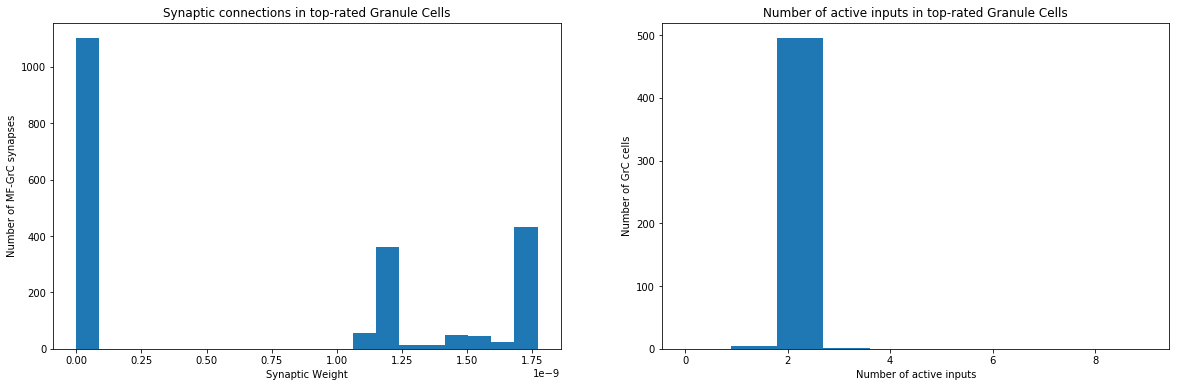

In [20]:
target_cells = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
source_cells = simulation.cerebellum.layer_map['mfgrcsynapsis'].source_index
weight = simulation.cerebellum.layer_map['mfgrcsynapsis'].weights
top_cell_index = numpy.in1d(target_cells, top_neurons)
target_top_cells = target_cells[top_cell_index]
source_top_cells = source_cells[top_cell_index]
weight_top = weight[top_cell_index]
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.hist(weight_top, bins=20)
plt.title('Synaptic connections in top-rated Granule Cells')
plt.xlabel('Synaptic Weight')
plt.ylabel('Number of MF-GrC synapses')
max_weight = numpy.max(weight)
active_synapses_top = weight_top>max_weight*0.2
number_of_active_inputs_top = numpy.bincount(target_top_cells[active_synapses_top],minlength=simulation.cerebellum.layer_map['grclayer'].number_of_neurons)
number_of_active_inputs_top = number_of_active_inputs_top[top_neurons]
plt.subplot(1,2,2)
plt.hist(number_of_active_inputs_top, bins=10, range=(0,9))
plt.title('Number of active inputs in top-rated Granule Cells')
plt.ylabel('Number of GrC cells')
plt.xlabel('Number of active inputs')
print 'Number of active synapses MF-GrC in top-%s Granule Cells:'%n,numpy.count_nonzero(active_synapses_top)

Map of input synaptic patterns and neuron response

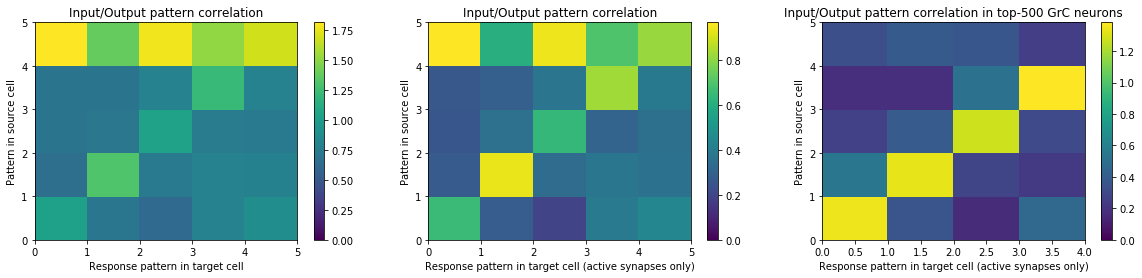

In [21]:
selected_pattern = numpy.argmax(extended_hit, axis=0)
pattern_per_synapsis = selected_pattern[target_cells]
activity_synapsis_map = numpy.zeros((simulation.pattern_generator.number_of_patterns+1,simulation.pattern_generator.number_of_patterns+1))
fibers_in_pattern = []
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(source_cells, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    activity_pattern = pattern_per_synapsis[included_in_pattern]
    activity_synapsis_map[pat_id,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)
    fibers_in_pattern += simulation.pattern_generator.fibers_in_pattern[pat_id,:].tolist()
no_pattern_fibers = numpy.in1d(source_cells, fibers_in_pattern,invert=True)
activity_pattern = pattern_per_synapsis[no_pattern_fibers]
activity_synapsis_map[simulation.pattern_generator.number_of_patterns,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)
activity_synapsis_map[:,:] = activity_synapsis_map[:,:]/numpy.bincount(selected_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)[None,:]
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.pcolor(activity_synapsis_map[:,:],vmin=0.000)
plt.colorbar()
plt.xlabel('Response pattern in target cell')
plt.ylabel('Pattern in source cell')
plt.title('Input/Output pattern correlation')

# Consider only active synapses
max_weight = numpy.max(weight)
active_synapses = weight>max_weight*0.2
active_target_cells = target_cells[active_synapses]
active_source_cells = source_cells[active_synapses]
active_weights = weight[active_synapses]
pattern_per_active_synapsis = selected_pattern[active_target_cells]
activity_active_synapsis_map = numpy.zeros((simulation.pattern_generator.number_of_patterns+1,simulation.pattern_generator.number_of_patterns+1))
fibers_in_pattern = []
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(active_source_cells, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    activity_pattern = pattern_per_active_synapsis[included_in_pattern]
    activity_active_synapsis_map[pat_id,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)
    fibers_in_pattern += simulation.pattern_generator.fibers_in_pattern[pat_id,:].tolist()
no_pattern_fibers = numpy.in1d(active_source_cells, fibers_in_pattern,invert=True)
activity_pattern = pattern_per_active_synapsis[no_pattern_fibers]
activity_active_synapsis_map[simulation.pattern_generator.number_of_patterns,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)
activity_active_synapsis_map[:,:] = activity_active_synapsis_map[:,:]/numpy.bincount(selected_pattern,minlength=simulation.pattern_generator.number_of_patterns+1)[None,:]
plt.subplot(1,3,2)
plt.pcolor(activity_active_synapsis_map[:,:],vmin=0.000)
plt.colorbar()
plt.xlabel('Response pattern in target cell (active synapses only)')
plt.ylabel('Pattern in source cell')
plt.title('Input/Output pattern correlation')

# Consider only active synapses and top-ranked neurons
max_weight = numpy.max(weight)
active_top_synapses = weight_top>max_weight*0.2
active_target_top_cells = target_top_cells[active_top_synapses]
active_source_top_cells = source_top_cells[active_top_synapses]
active_top_weights = weight_top[active_top_synapses]
pattern_per_active_synapsis = selected_pattern[active_target_top_cells]
activity_active_top_synapsis_map = numpy.zeros((simulation.pattern_generator.number_of_patterns+1,simulation.pattern_generator.number_of_patterns))
fibers_in_pattern = []
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(active_source_top_cells, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    activity_pattern = pattern_per_active_synapsis[included_in_pattern]
    activity_active_top_synapsis_map[pat_id,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns)
    fibers_in_pattern += simulation.pattern_generator.fibers_in_pattern[pat_id,:].tolist()
no_pattern_fibers = numpy.in1d(active_source_top_cells, fibers_in_pattern,invert=True)
activity_pattern = pattern_per_active_synapsis[no_pattern_fibers]
activity_active_top_synapsis_map[simulation.pattern_generator.number_of_patterns,:] = numpy.bincount(activity_pattern,minlength=simulation.pattern_generator.number_of_patterns)
activity_active_top_synapsis_map[:,:] = activity_active_top_synapsis_map[:,:]/numpy.bincount(selected_pattern[top_neurons],minlength=simulation.pattern_generator.number_of_patterns)[None,:]
plt.subplot(1,3,3)
plt.pcolor(activity_active_top_synapsis_map[:,:],vmin=0.000)
plt.colorbar()
plt.xlabel('Response pattern in target cell (active synapses only)')
plt.ylabel('Pattern in source cell')
plt.title('Input/Output pattern correlation in top-%s GrC neurons'%n)

Since most of top-ranked neurons accounts 2 active inputs we must check whether those inputs are part of the same pattern and, if so, the corresponding activation levels.

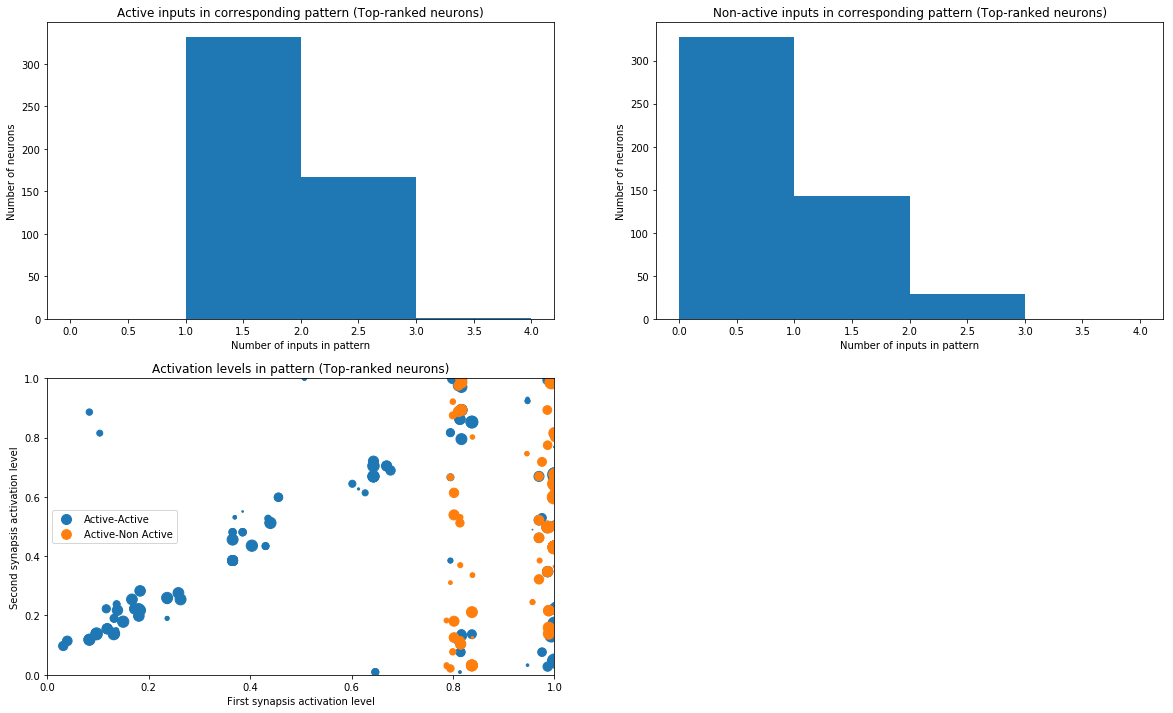

In [22]:
active_inputs_in_pattern = []
non_active_inputs_in_pattern = []
first_component_activation = []
second_component_activation = []
mark_size_active = []
component_active = []
component_non_active = []
mark_size_non_active = []
norm_hit_fa_diff_top = 200*(hit_fa_diff_top-numpy.min(hit_fa_diff_top))/(numpy.max(hit_fa_diff_top)-numpy.min(hit_fa_diff_top))
for neuron_id, pattern_id, hit_false in zip(top_neurons,top_patterns,norm_hit_fa_diff_top):
    # Recover the active synapses of such neuron
    id_synapses = (target_cells==neuron_id)
    source_neurons = source_cells[id_synapses]
    weights = weight[id_synapses]
    # Check the number of inputs in pattern
    index_in_pattern = numpy.in1d(source_neurons,simulation.pattern_generator.fibers_in_pattern[pattern_id,:])
    num_in_pattern = numpy.count_nonzero(index_in_pattern)
    # Print the weight and the activation levels
    activation_level = [simulation.pattern_generator.pattern_activation[pattern_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pattern_id,:]==source)[0][0]] 
                    for source in source_neurons[index_in_pattern]]
#    print 'Neuron:',neuron_id,'Pattern:',pattern_id,'Activation levels:',activation_level,'Weights:',weights[index_in_pattern]    
    # Check active synapses
    index_in_pattern_active = (weights[index_in_pattern]>max_weight*0.2)
    index_in_pattern_non_active = (weights[index_in_pattern]<=max_weight*0.2)
    active = numpy.count_nonzero(index_in_pattern_active)
    non_active = num_in_pattern - active
    active_inputs_in_pattern.append(active)
    non_active_inputs_in_pattern.append(non_active)
#    print 'Neuron',neuron_id,'receives',active,'active and',non_active,'non-active synapses from its pattern',pattern_id
    if (active==2):
        ordered_weights = numpy.argsort(weights[index_in_pattern][index_in_pattern_active])
        source_fibers = source_neurons[index_in_pattern][index_in_pattern_active][ordered_weights[-2:]]
        activation_level = [simulation.pattern_generator.pattern_activation[pattern_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pattern_id,:]==source)[0][0]] 
                    for source in source_fibers]
        first_component_activation.append(activation_level[1])
        second_component_activation.append(activation_level[0])
        mark_size_active.append(hit_false)
    elif (active==1 and non_active==1):
        active_source_fiber = source_neurons[index_in_pattern][index_in_pattern_active]
        non_active_source_fiber = source_neurons[index_in_pattern][index_in_pattern_non_active]
        active_activation_level = [simulation.pattern_generator.pattern_activation[pattern_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pattern_id,:]==source)[0][0]] 
                    for source in active_source_fiber]
        non_active_activation_level = [simulation.pattern_generator.pattern_activation[pattern_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pattern_id,:]==source)[0][0]] 
                    for source in non_active_source_fiber]
        component_active.append(active_activation_level)
        component_non_active.append(non_active_activation_level)
        mark_size_non_active.append(hit_false)
        
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.hist(active_inputs_in_pattern, bins=4, range=(0,4))
plt.title('Active inputs in corresponding pattern (Top-ranked neurons)')
plt.ylabel('Number of neurons')
plt.xlabel('Number of inputs in pattern')
plt.subplot(2,2,2)
plt.hist(non_active_inputs_in_pattern, bins=4, range=(0,4))
plt.title('Non-active inputs in corresponding pattern (Top-ranked neurons)')
plt.ylabel('Number of neurons')
plt.xlabel('Number of inputs in pattern')
plt.subplot(2,2,3)
#plt.plot(first_component_activation, second_component_activation, '.',markersize=mark_size_active,label='Active-Active')
#plt.plot(component_active, component_non_active, '.',markersize=mark_size_non_active,label='Active-Non Active')
plt.scatter(first_component_activation, second_component_activation, marker='o', s=mark_size_active, label='Active-Active')
plt.scatter(component_active, component_non_active, marker='o', s=mark_size_non_active, label='Active-Non Active')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Activation levels in pattern (Top-ranked neurons)')
plt.ylabel('Second synapsis activation level')
plt.xlabel('First synapsis activation level')
plt.legend()

Now plot the activation levels in the active inputs every time a top-ranked neuron spikes

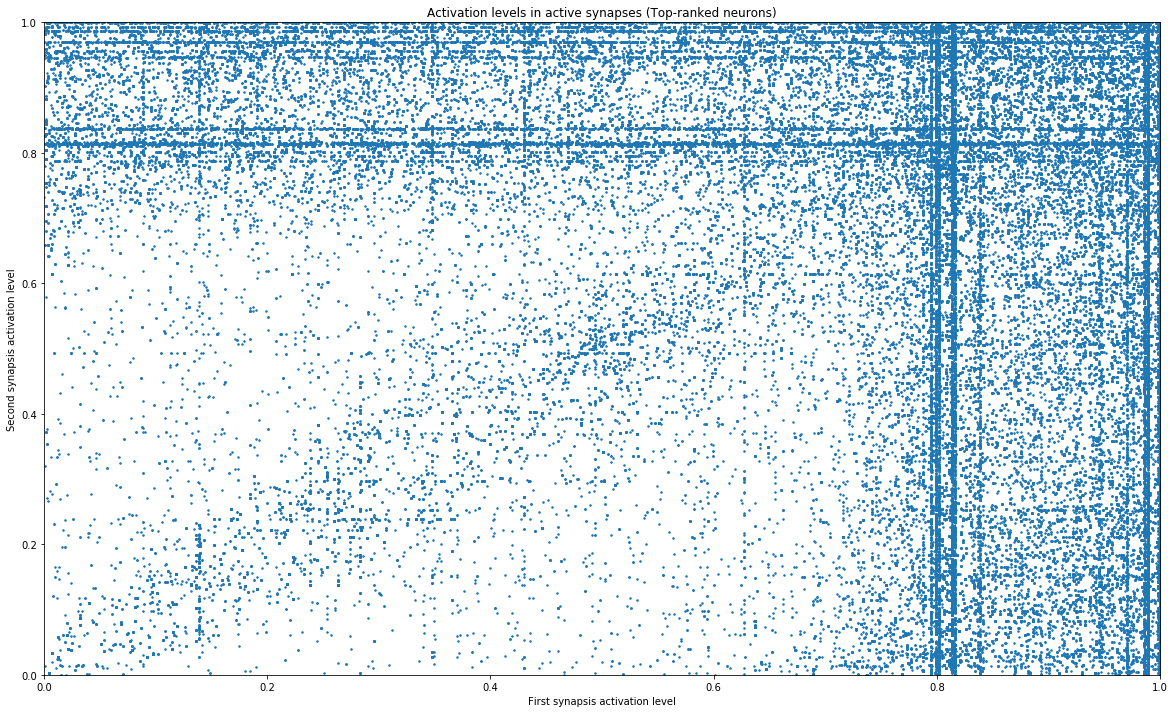

In [23]:
gtime_grc,gcell_id_grc = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = simulation_time-100.0, 
                                                          end_time = simulation_time)
# Get spike activity of top-ranked neurons
index_top_neurons = numpy.in1d(gcell_id_grc,top_neurons)
gtime_top = gtime_grc[index_top_neurons]
gcell_id_top = gcell_id_grc[index_top_neurons]
# Get active synapses
index_active = weight_top>max_weight*0.2
source_top_active = source_top_cells[index_active]
target_top_active = target_top_cells[index_active]
# Get stimulation bins
stim_bin = numpy.searchsorted(simulation.pattern_generator.pattern_length_cum,gtime_top)
# Create the activation lists
first_activation_level = []
second_activation_level = []
for time_bin,cell_id in zip(stim_bin,gcell_id_top):
    # Get active synapses for cell_id
    active_source = source_top_active[target_top_active==cell_id]
    if len(active_source)==2:
        first_activation_level.append(simulation.pattern_generator.activation_levels[time_bin,active_source[0]])
        second_activation_level.append(simulation.pattern_generator.activation_levels[time_bin,active_source[1]])
plt.figure(figsize=(20,12))
plt.plot(first_activation_level, second_activation_level, '.',markersize=3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Activation levels in active synapses (Top-ranked neurons)')
plt.ylabel('Second synapsis activation level')
plt.xlabel('First synapsis activation level')

Now plot the activation levels in the active inputs every time considering all neuron spikes

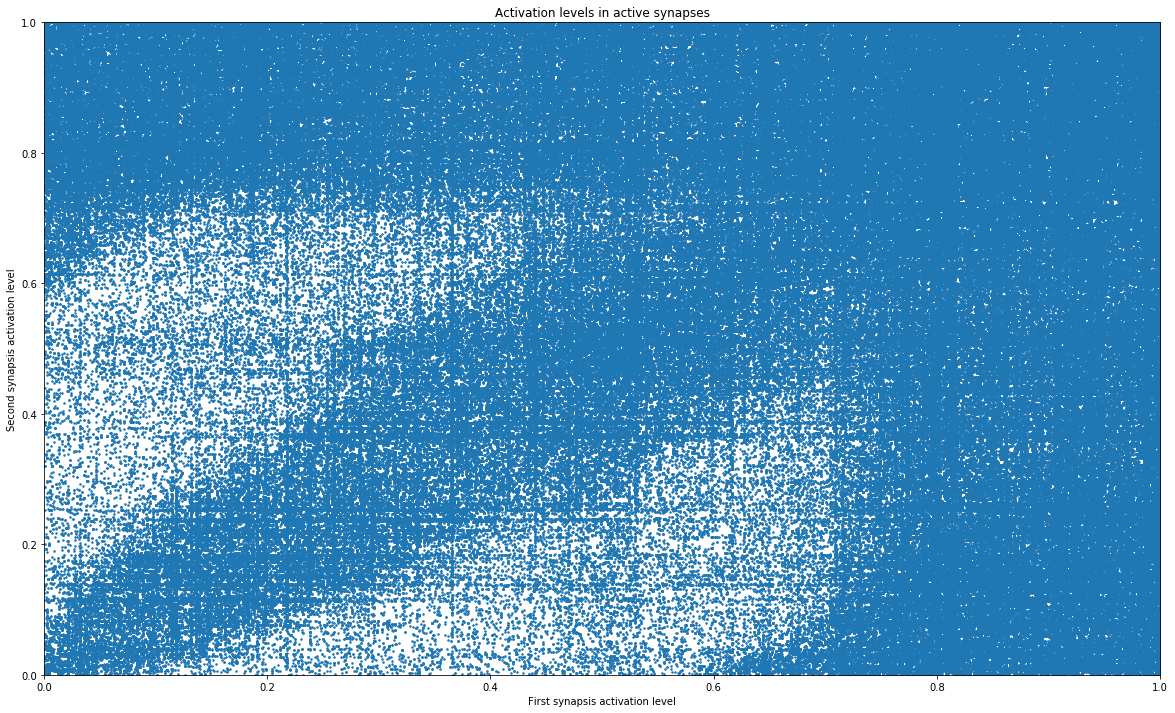

In [24]:
gtime_grc,gcell_id_grc = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = simulation_time-100.0, 
                                                          end_time = simulation_time)
# Get active synapses
target_cells = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
source_cells = simulation.cerebellum.layer_map['mfgrcsynapsis'].source_index
weight = simulation.cerebellum.layer_map['mfgrcsynapsis'].weights
index_active = weight>numpy.max(weight)*0.2
source_active = source_cells[index_active]
target_active = target_cells[index_active]
# Get stimulation bins
stim_bin = numpy.searchsorted(simulation.pattern_generator.pattern_length_cum,gtime_grc)
# Create the activation lists
first_activation_level = []
second_activation_level = []
for time_bin,cell_id in zip(stim_bin,gcell_id_grc):
    # Get active synapses for cell_id
    active_source = source_active[target_active==cell_id]
    if len(active_source)==2:
        first_activation_level.append(simulation.pattern_generator.activation_levels[time_bin,active_source[0]])
        second_activation_level.append(simulation.pattern_generator.activation_levels[time_bin,active_source[1]])
plt.figure(figsize=(20,12))
plt.plot(first_activation_level, second_activation_level, '.',markersize=3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Activation levels in active synapses')
plt.ylabel('Second synapsis activation level')
plt.xlabel('First synapsis activation level')

## Weight Analysis after Learning

Weight distribution per source cell pattern

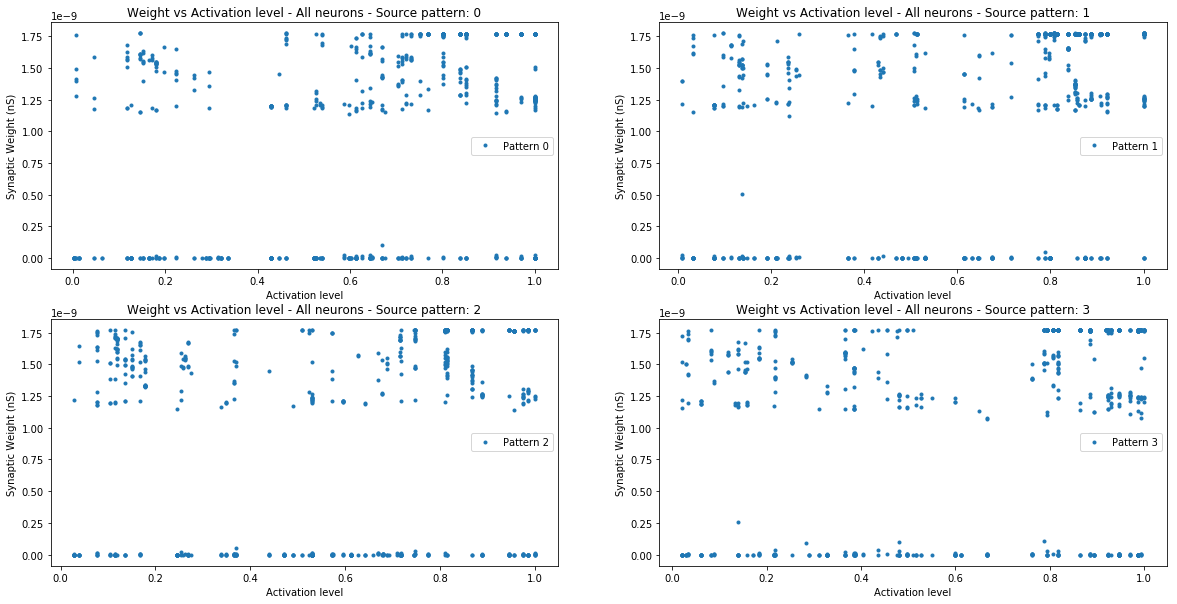

In [25]:
import math
plt.figure(figsize=(20,10))
for source_pat_id in range(simulation.pattern_generator.number_of_patterns):
    # Select those synapses included in pattern source_pat_id
    indexes_in_pattern = numpy.in1d(source_cells, simulation.pattern_generator.fibers_in_pattern[source_pat_id,:])
    source_cells_in_pattern = source_cells[indexes_in_pattern]
    target_cells_in_pattern = target_cells[indexes_in_pattern]
    weights_in_pattern = weight[indexes_in_pattern]
    firing_pattern_in_pattern = selected_pattern[target_cells_in_pattern]
    indexes_in_pattern_description = numpy.array([numpy.where(source_id==simulation.pattern_generator.fibers_in_pattern[source_pat_id,:])[0][0] for source_id in source_cells_in_pattern])
    activation_level_in_pattern = simulation.pattern_generator.pattern_activation[source_pat_id,indexes_in_pattern_description]
    plt.subplot(math.ceil(simulation.pattern_generator.number_of_patterns/2),2,source_pat_id+1)
    target_pat_id = source_pat_id
#    for target_pat_id in range(simulation.pattern_generator.number_of_patterns):
    # Select those cells mainly responding to pattern target_pat_id
    indexes_in_target_pattern = numpy.where(firing_pattern_in_pattern==target_pat_id)[0]
    plt.plot(activation_level_in_pattern[indexes_in_target_pattern], weights_in_pattern[indexes_in_target_pattern],'.',label='Pattern %s'%target_pat_id)
    plt.xlabel('Activation level')
    plt.ylabel('Synaptic Weight (nS)')
    plt.legend()
    plt.title('Weight vs Activation level - All neurons - Source pattern: %s'%source_pat_id)

Weight distribution per source cell pattern in top-ranked cells

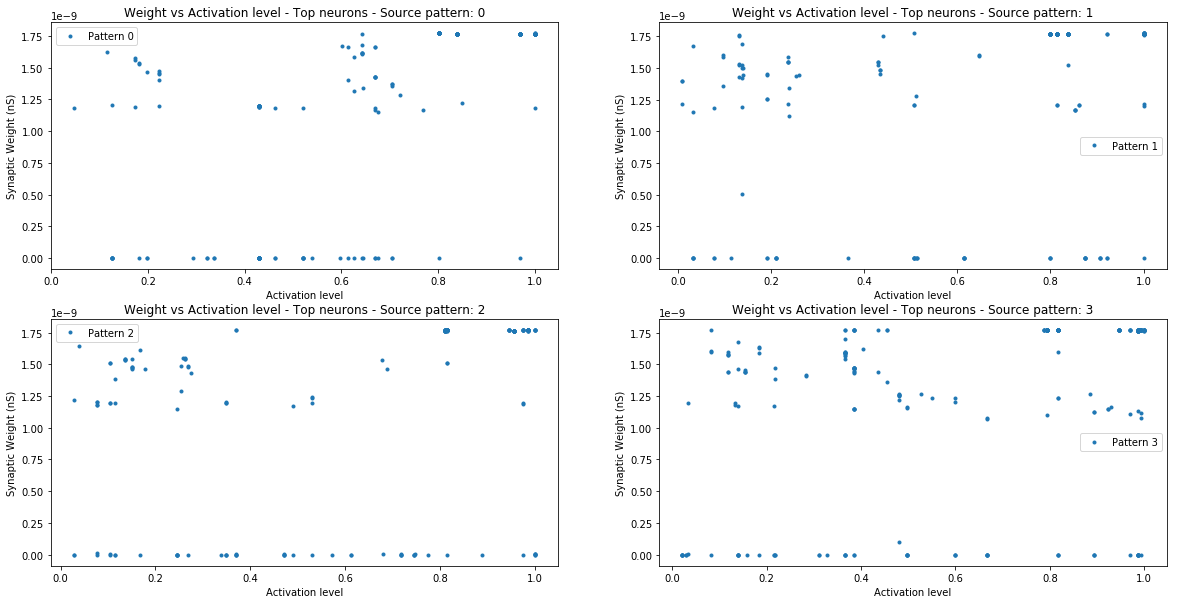

In [26]:
plt.figure(figsize=(20,10))
for source_pat_id in range(simulation.pattern_generator.number_of_patterns):
    # Select those synapses included in pattern source_pat_id
    indexes_in_pattern = numpy.in1d(source_top_cells, simulation.pattern_generator.fibers_in_pattern[source_pat_id,:])
    source_cells_in_pattern = source_top_cells[indexes_in_pattern]
    target_cells_in_pattern = target_top_cells[indexes_in_pattern]
    weights_in_pattern = weight_top[indexes_in_pattern]
    firing_pattern_in_pattern = selected_pattern[target_cells_in_pattern]
    indexes_in_pattern_description = numpy.array([numpy.where(source_id==simulation.pattern_generator.fibers_in_pattern[source_pat_id,:])[0][0] for source_id in source_cells_in_pattern])
    activation_level_in_pattern = simulation.pattern_generator.pattern_activation[source_pat_id,indexes_in_pattern_description]
    plt.subplot(math.ceil(simulation.pattern_generator.number_of_patterns/2),2,source_pat_id+1)
    #for target_pat_id in range(simulation.pattern_generator.number_of_patterns):
        # Select those cells mainly responding to pattern target_pat_id
    target_pat_id = source_pat_id
    indexes_in_target_pattern = numpy.where(firing_pattern_in_pattern==target_pat_id)[0]
    plt.plot(activation_level_in_pattern[indexes_in_target_pattern], weights_in_pattern[indexes_in_target_pattern],'.',label='Pattern %s'%target_pat_id)
    plt.xlabel('Activation level')
    plt.ylabel('Synaptic Weight (nS)')
    plt.legend()
    plt.title('Weight vs Activation level - Top neurons - Source pattern: %s'%source_pat_id)

## Firing Offset Analysis

Plot firing offset as the simulation advances

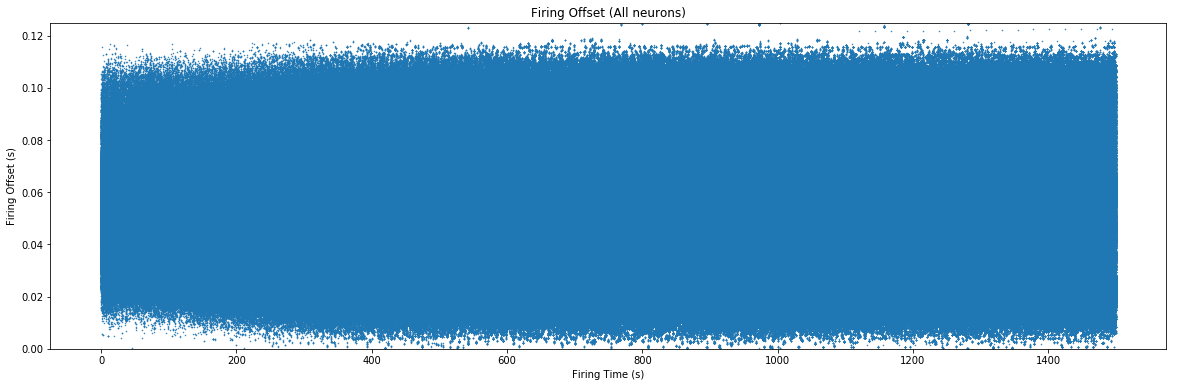

In [27]:
gtime_all,gcell_id_all = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = 0, 
                                                            end_time = simulation_time)
firing_offset = numpy.mod(gtime_all,1./oscillation_frequency)
plt.figure(figsize=(20,6))
plt.plot(gtime_all,firing_offset,'.',markersize=1)
plt.ylim([0,1./oscillation_frequency])
plt.xlabel('Firing Time (s)')
plt.ylabel('Firing Offset (s)')
plt.title('Firing Offset (All neurons)')

Plot firing offset in top-rated neurons

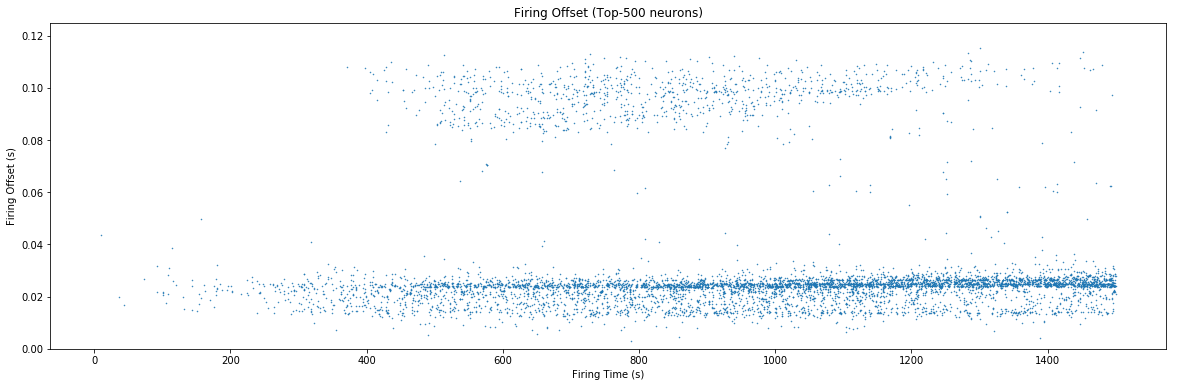

In [28]:
# Select spikes in top-rated neurons
gtime_all_top = gtime_all[numpy.in1d(gcell_id_all,top_cell_index)]
firing_offset = numpy.mod(gtime_all_top,1./oscillation_frequency)
plt.figure(figsize=(20,6))
plt.plot(gtime_all_top,firing_offset,'.',markersize=1)
plt.ylim([0,1./oscillation_frequency])
plt.xlabel('Firing Time (s)')
plt.ylabel('Firing Offset (s)')
plt.title('Firing Offset (Top-%s neurons)'%n)

## Pattern covariance analysis

Calculate the covariance matrix of hits

[[ 0.01652445  0.00552561  0.00682318  0.00512556]
 [ 0.00552561  0.01803254  0.00492767  0.00813995]
 [ 0.00682318  0.00492767  0.01435814  0.00554698]
 [ 0.00512556  0.00813995  0.00554698  0.01870654]]


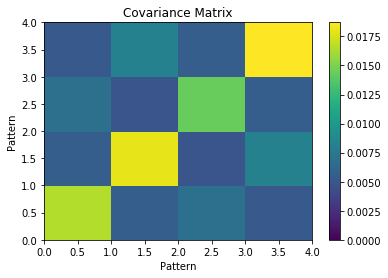

In [29]:
# Calculate the hit rate average for each pattern
pattern_average = numpy.average(hit_matrix, axis=1)
diff_matrix = numpy.zeros(hit_matrix.shape)
# Calculate the difference between the hit rate of each neuron and the average hit rate to each pattern
for pat in range(hit_matrix.shape[0]):
    diff_matrix[pat,:] = hit_matrix[pat,:] - pattern_average[pat]
# Calculate the covariance matrix
cov_matrix = numpy.zeros((hit_matrix.shape[0],hit_matrix.shape[0]))
for pat in range(hit_matrix.shape[0]):
    for pat2 in range(hit_matrix.shape[0]):
        cov_matrix[pat,pat2] = numpy.average(diff_matrix[pat,:]*diff_matrix[pat2,:])
print cov_matrix
plt.figure()
plt.pcolor(cov_matrix,vmin=0.000)
plt.colorbar()
plt.xlabel('Pattern')
plt.ylabel('Pattern')
plt.title('Covariance Matrix')

## Perceptron Learning

Extract the information representation in mossy fibers and granule cells

In [36]:
# Create dataset with the ending analysis_time seconds
grc_activity_matrix = create_cell_firing_matrix('grclayer', simulation_time-analysis_time, analysis_time, 0.125).T
print grc_activity_matrix.shape
stimulation_matrix = create_input_activation_matrix( simulation_time-analysis_time, analysis_time, 0.125).T
print stimulation_matrix.shape
pattern_activation_matrix = create_active_pattern_matrix( simulation_time-analysis_time, analysis_time, 0.125).T
print pattern_activation_matrix.shape
# Standarize the input data
std_grc_activity_matrix = grc_activity_matrix - numpy.mean(grc_activity_matrix, axis=0)
std_grc_activity_matrix = std_grc_activity_matrix / numpy.std(std_grc_activity_matrix, axis=0)
std_stimulation_matrix = stimulation_matrix - numpy.mean(stimulation_matrix, axis=0)
std_stimulation_matrix = std_stimulation_matrix / numpy.std(std_stimulation_matrix, axis=0)
# Create training and test datasets
val_ratio = 0.8
val_n_elements = int(numpy.floor(grc_activity_matrix.shape[0]*val_ratio))
test_n_elements = grc_activity_matrix.shape[0] - val_n_elements
choice_order = numpy.random.choice(grc_activity_matrix.shape[0],grc_activity_matrix.shape[0])
validation = choice_order[:val_n_elements]
test = choice_order[-test_n_elements:]

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


(4000, 4000)
(4000, 300)
(4000, 4)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:148: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:149: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Teach a single-layer perceptron with the stimulation matrix

In [41]:
import keras.models
import keras.layers
# load and prepare the dataset
mf_model = keras.models.Sequential()
mf_layer = keras.layers.Dense(simulation.pattern_generator.number_of_patterns, input_dim=stimulation_matrix.shape[1], activation='sigmoid')
mf_model.add(mf_layer)
mf_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
mf_history = mf_model.fit(std_stimulation_matrix[validation,:], pattern_activation_matrix[validation,:], nb_epoch=1000, batch_size=stimulation_matrix.shape[0]/10)

Epoch 1/1000
3200/3200 [==============================] - 0s - loss: 0.8951 - acc: 0.4991     
Epoch 2/1000
3200/3200 [==============================] - 0s - loss: 0.8886 - acc: 0.5012     
Epoch 3/1000
3200/3200 [==============================] - 0s - loss: 0.8824 - acc: 0.5028     
Epoch 4/1000
3200/3200 [==============================] - 0s - loss: 0.8764 - acc: 0.5041     
Epoch 5/1000
3200/3200 [==============================] - 0s - loss: 0.8706 - acc: 0.5071     
Epoch 6/1000
3200/3200 [==============================] - 0s - loss: 0.8649 - acc: 0.5074     

Teach a single-layer perceptron with the granular layer activity matrix

In [42]:
import keras.models
import keras.layers
# load and prepare the dataset
gc_model = keras.models.Sequential()
gc_layer = keras.layers.Dense(simulation.pattern_generator.number_of_patterns, input_dim=grc_activity_matrix.shape[1], activation='sigmoid')
gc_model.add(gc_layer)
gc_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
gc_history = gc_model.fit(std_grc_activity_matrix[validation,:], pattern_activation_matrix[validation,:], nb_epoch=1000, batch_size=grc_activity_matrix.shape[0]/10)

Epoch 1/1000
3200/3200 [==============================] - 0s - loss: 0.8372 - acc: 0.5385     
Epoch 2/1000
3200/3200 [==============================] - 0s - loss: 0.6613 - acc: 0.6492     
Epoch 3/1000
3200/3200 [==============================] - 0s - loss: 0.5618 - acc: 0.7174     

Plot the accuracy evolution during learning

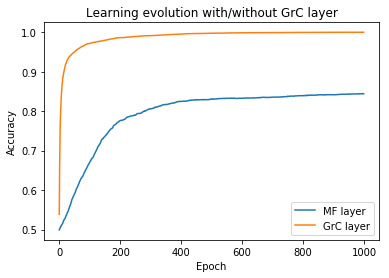

In [43]:
plt.figure()
plt.plot(mf_history.history['acc'],label='MF layer')
plt.plot(gc_history.history['acc'],label='GrC layer')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning evolution with/without GrC layer')

In [44]:
print 'Test set prediction mf layer', mf_model.evaluate(std_stimulation_matrix[test,:], pattern_activation_matrix[test,:], batch_size=test_n_elements)
print 'Test set prediction grc layer',gc_model.evaluate(std_grc_activity_matrix[test,:], pattern_activation_matrix[test,:], batch_size=test_n_elements)

800/800 [==============================] - 0s
 [0.43421974778175354, 0.8162500262260437]
800/800 [==============================] - 0s
 [0.13698749244213104, 0.96375000476837158]
